## Super Resolution Project Group 2
##### Miro Hintikka, Teemu Kallio, Sara Pappila, Kirill Saveliev


In this project we aim to create a super-resolution model that can increase the resolution of images. We chose the DIV2K dataset, which contains high-resolution images. From high resolution pictures we crop into smaller pictures as our training data and we add blur to them. The model is based on a Enhanced Deep Residual Networks (EDSR) for Single Image Super-Resolution. https://keras.io/examples/vision/edsr/

## Super Resolution Project Group 2

#### Miro Hintikka, Teemu Kallio, Sara Pappila, Kirill Saveliev


In this project we aim to create a super-resolution model that can increase the resolution of images. 
We chose the DIV2K dataset, which contains high-resolution images. From high resolution pictures we crop into smaller pictures as our training data and we add blur to them.
The model is based on a Enhanced Deep Residual Networks (EDSR) for Single Image Super-Resolution. 
https://keras.io/examples/vision/edsr/

#### Imports

In [1]:
import numpy as np
import gradio as gr
from zipfile import ZipFile
import os
import requests
import random
import shutil
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers, Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.applications.vgg19 import preprocess_input
from tensorflow.keras.utils import register_keras_serializable
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay

2025-05-08 19:04:34.514849: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746720274.531077   10024 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746720274.536030   10024 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746720274.548262   10024 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746720274.548284   10024 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746720274.548286   10024 computation_placer.cc:177] computation placer alr

### Data Download

To use the dataset, you need to download and extract the DIV2K dataset, which contains both training and validation high-resolution images.

This script will automatically download and extract the dataset into a specified directory.

**Important:** Only run this script if you haven't already downloaded or extracted the dataset. If the dataset is already available, you can skip this step.

In [3]:
'''urls = [
    "http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip",
    "http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip"
]

data_dir = "../loppuprojekti/data"
os.makedirs(data_dir, exist_ok=True)

for url in urls:
    filename = os.path.join(data_dir, os.path.basename(url))
    # Download zip file
    print(f"Downloading {url}...")
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
    print("Download ready:", filename)
    # Exctract zip file
    print(f"Extracting {filename}...")
    with ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall(data_dir)
    print("Extracted files!")

print("Data pulling ready:", data_dir)'''

Download ready: ../loppuprojekti/data/DIV2K_valid_HR.zip
Extracting ../loppuprojekti/data/DIV2K_valid_HR.zip...
Extracted files!
Download ready: ../loppuprojekti/data/DIV2K_train_HR.zip
Extracting ../loppuprojekti/data/DIV2K_train_HR.zip...
Extracted files!
Data pulling ready: ../loppuprojekti/data


### Data Preparation

This code splits the training dataset by moving 15% of the images from the training folder into a separate test folder

In [2]:
# For GPU logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

data_dir = "../loppuprojekti/data"
train = "../loppuprojekti/data/DIV2K_train_HR/"
validation = "../loppuprojekti/data/DIV2K_valid_HR/"
test = "../loppuprojekti/data/DIV2K_test_HR"

os.makedirs(test, exist_ok=True)

train_files = os.listdir(train)

num_test_files = int(len(train_files) * 0.15)

files_to_move = random.sample(train_files, num_test_files)

if not os.listdir(test):
    for file in files_to_move:
        src = os.path.join(train, file)
        dst = os.path.join(test, file)
        shutil.move(src, dst)

    print(f"Moved {len(files_to_move)} files to test directory")

else:
    print("Test files already exist")

Test files already exist


#### Data Augmentation Helper Functions

These functions apply random data augmentation techniques to both low-resolution (LR) and high-resolution (HR) images, which helps improve the model's generalization during training.

In [5]:
def flip_left_right(lowres_img, highres_img):
    """Flips Images to left and right."""

    # Outputs random values from a uniform distribution in between 0 to 1
    rn = tf.random.uniform(shape=(), maxval=1.0)

    # If rn is less than 0.5 it returns original lowres_img and highres_img
    # If rn is greater than 0.5 it returns flipped image
    return tf.cond(
        rn < 0.5,
        lambda: (lowres_img, highres_img),
        lambda: (
            tf.image.flip_left_right(lowres_img),
            tf.image.flip_left_right(highres_img),
        ),
    )


def random_rotate(lowres_img, highres_img):
    """Rotates Images by 90 degrees."""

    # Outputs random values from uniform distribution in between 0 to 4
    rn = tf.cast(tf.random.uniform(shape=(), maxval=4, dtype=tf.float32), dtype=tf.int32)

    # Here rn signifies number of times the image(s) are rotated by 90 degrees
    return tf.image.rot90(lowres_img, rn), tf.image.rot90(highres_img, rn)

#### Utility Functions

This cell defines reusable components used throughout the project. It includes the pre-trained VGG19 feature extractor and a combined perceptual-pixel loss function used during training, as well as helper functions and custom layers for model evaluation and serialization.

In [2]:
vgg = keras.applications.VGG19(include_top=False, weights="imagenet")
vgg.trainable = False
vgg_model = Model(inputs=vgg.input, outputs=vgg.get_layer("block3_conv3").output)


def preprocess_vgg(x):
    x = tf.image.resize(x, [224, 224])
    x = preprocess_input(x * 255.0)
    return x

def combined_loss(y_true, y_pred):
    # Preprocess for VGG
    y_true_vgg = preprocess_vgg(y_true)
    y_pred_vgg = preprocess_vgg(y_pred)

    # Extract features
    f_true = vgg_model(y_true_vgg)
    f_pred = vgg_model(y_pred_vgg)

    # Perceptual loss: feature-wise MSE
    perceptual = tf.reduce_mean(tf.square(f_true - f_pred))
    pixel = tf.reduce_mean(tf.abs(y_true - y_pred))
    return 0.000001 * perceptual + 1.0 * pixel

@register_keras_serializable()
class PixelShuffle(layers.Layer):
    def __init__(self, scale, **kwargs):
        super().__init__(**kwargs)
        self.scale = scale

    def call(self, inputs):
        return tf.nn.depth_to_space(inputs, block_size=self.scale)

    def get_config(self):
        config = super().get_config()
        config.update({"scale": self.scale})
        return config

@register_keras_serializable()
def load_model(filepath):
    return keras.models.load_model(
    filepath,
    custom_objects={
        "PixelShuffle": PixelShuffle,
        "combined_loss": combined_loss,
        "PSNR": PSNR,
        "SSIM": SSIM,
        "PiecewiseConstantDecay": PiecewiseConstantDecay
    },
)

@register_keras_serializable()
def PSNR(original, generated):
    return tf.image.psnr(original, generated, max_val=1.0)

@register_keras_serializable()
def SSIM(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

I0000 00:00:1746720306.533797   10024 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6687 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:0a:00.0, compute capability: 6.1


#### Dataset Creation

We create the dataset by applying random cropping to each high-resolution image. While this technique is not ideal for evaluating performance on full-size images, it provides a fast and memory-efficient way to train the model using smaller, diverse patches.

Each cropped patch is:
- Downscaled to simulate a low-resolution version (input).
- Paired with the original high-resolution patch (target).

This setup allows the model to learn super-resolution mappings using small image patches, which significantly reduces computational overhead during training.

In [6]:
AUTOTUNE = tf.data.AUTOTUNE
crop_size = 192
scale = 4

train_dir = os.path.join(data_dir, "DIV2K_train_HR")
val_dir = os.path.join(data_dir, "DIV2K_valid_HR")
test_dir = os.path.join(data_dir, "DIV2K_test_HR")

train_files = [
    os.path.join(train_dir, fname)
    for fname in os.listdir(train_dir)
    if fname.lower().endswith((".png", ".jpg", ".jpeg"))
]

val_files = [
    os.path.join(val_dir, fname)
    for fname in os.listdir(val_dir)
    if fname.lower().endswith((".png", ".jpg", ".jpeg"))
]

test_files = [
    os.path.join(test_dir, fname)
    for fname in os.listdir(test_dir)
    if fname.lower().endswith((".png", ".jpg", ".jpeg"))
]

def random_crop_and_downscale(hr_img):
    hr_patch = tf.image.random_crop(hr_img, size=[crop_size, crop_size, 3])
    hr_patch.set_shape([crop_size, crop_size, 3])
    lr_patch = tf.image.resize(
        hr_patch, [crop_size // scale, crop_size // scale], method="area"
    )
    lr_patch.set_shape([crop_size // scale, crop_size // scale, 3])
    return lr_patch, hr_patch

# Build datasets

def load_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3)
    return tf.image.convert_image_dtype(img, tf.float32)

train_ds = tf.data.Dataset.from_tensor_slices(train_files).map(
    load_image, num_parallel_calls=tf.data.AUTOTUNE
)


val_ds = tf.data.Dataset.from_tensor_slices(val_files).map(
    load_image, num_parallel_calls=tf.data.AUTOTUNE
)


test_ds = tf.data.Dataset.from_tensor_slices(test_files).map(
    load_image, num_parallel_calls=tf.data.AUTOTUNE
)


# Apply random cropping and downscaling
BATCH_SIZE = 2

train_sr = train_ds.map(random_crop_and_downscale, num_parallel_calls=tf.data.AUTOTUNE)
train_sr = train_sr.map(random_rotate, num_parallel_calls=tf.data.AUTOTUNE)
train_sr = train_sr.map(flip_left_right, num_parallel_calls=tf.data.AUTOTUNE)
train_sr = train_sr.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_sr = val_ds.map(random_crop_and_downscale, num_parallel_calls=tf.data.AUTOTUNE)
val_sr = val_sr.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_sr = test_ds.map(random_crop_and_downscale, num_parallel_calls=tf.data.AUTOTUNE)
test_sr = test_sr.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Example: print shapes

for lr, hr in train_sr.take(1):
    print("LR patch shape:", lr.shape)
    print("HR patch shape:", hr.shape)
#### Plot Example of Training Data

LR patch shape: (2, 48, 48, 3)
HR patch shape: (2, 192, 192, 3)


The image pair below illustrates a low-resolution input and its corresponding high-resolution target, as used across training, validation, and test datasets.

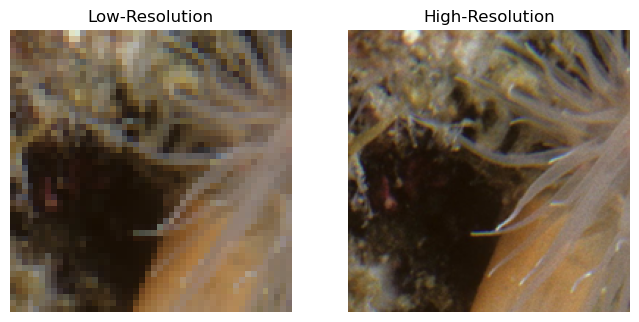

In [7]:
# Get one LR-HR pair from the dataset
for lr, hr in train_sr.take(1):
    lr_img = lr.numpy()
    hr_img = hr.numpy()

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title("Low-Resolution")
    plt.imshow(lr_img[0])
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("High-Resolution")
    plt.imshow(hr_img[0])
    plt.axis("off")

    plt.show()

#### Callbacks

This cell defines training callbacks to improve model performance and prevent overfitting.

In [8]:
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1
)

early_stop = EarlyStopping(
    monitor="val_loss",  # or val_calculate_psnr for PSNR
    patience=20,
    restore_best_weights=True,
    mode='min'
)

early_stop_comb = EarlyStopping(
    monitor="val_SSIM",
    patience=30,
    restore_best_weights=True,
    mode='max'
)

#### Model Construction

Defines the architecture of the super-resolution model, including residual blocks for feature learning and upsampling layers for image resolution enhancement. The `make_model` function builds and returns the full model.

In [9]:
# Residual block layers
def ResBlock(inputs, filters):
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(inputs)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.Add()([inputs, x])
    return x


# Up sampling layer
def Upsampling(inputs, factor=2, **kwargs):
    x = layers.Conv2D(64 * (factor**2), 3, padding="same", **kwargs)(inputs)
    x = PixelShuffle(factor)(x)
    x = layers.Conv2D(64 * (factor**2), 3, padding="same", **kwargs)(x)
    x = PixelShuffle(factor)(x)
    return x


# Model creation function
def make_model(num_filters, num_of_residual_blocks):
    input_layer = layers.Input(shape=(None, None, 3))
    x = x_new = layers.Conv2D(num_filters, 3, padding="same")(input_layer)

    for _ in range(num_of_residual_blocks):
        x_new = ResBlock(x_new, num_filters)

    x_new = layers.Conv2D(num_filters, 3, padding="same")(x_new)
    x = layers.Add()([x, x_new])

    x = Upsampling(x, factor=2)
    x = layers.Conv2D(3, 3, padding="same")(x)

    output_layer = layers.Activation("sigmoid")(x)
    return Model(inputs=input_layer, outputs=output_layer)


model = make_model(num_filters=256, num_of_residual_blocks=18)

**Phase 1 – Pretraining with MAE Loss**

We first train the model using the mean absolute error (MAE) loss. This phase helps the model learn a strong baseline for low-level reconstruction.

In [10]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss="mae", metrics=[PSNR, SSIM])
model.fit(
    train_sr, validation_data=val_sr, epochs=300, callbacks=[early_stop, reduce_lr]
)
model.save_weights("mae.weights.h5")

Epoch 1/300
400/400 [==============================] - 114s 256ms/step - loss: 0.1021 - PSNR: 19.1956 - SSIM: 0.4745 - val_loss: 0.0535 - val_PSNR: 23.3418 - val_SSIM: 0.6289 - lr: 1.0000e-04
Epoch 2/300
400/400 [==============================] - 102s 253ms/step - loss: 0.0516 - PSNR: 23.9621 - SSIM: 0.6707 - val_loss: 0.0440 - val_PSNR: 25.0624 - val_SSIM: 0.6926 - lr: 1.0000e-04
Epoch 3/300
400/400 [==============================] - 102s 253ms/step - loss: 0.0461 - PSNR: 25.0553 - SSIM: 0.7048 - val_loss: 0.0447 - val_PSNR: 25.1891 - val_SSIM: 0.7275 - lr: 1.0000e-04
Epoch 4/300
400/400 [==============================] - 102s 253ms/step - loss: 0.0413 - PSNR: 25.9572 - SSIM: 0.7226 - val_loss: 0.0376 - val_PSNR: 26.9901 - val_SSIM: 0.7474 - lr: 1.0000e-04
Epoch 5/300
400/400 [==============================] - 101s 252ms/step - loss: 0.0401 - PSNR: 26.2542 - SSIM: 0.7379 - val_loss: 0.0505 - val_PSNR: 24.4868 - val_SSIM: 0.7335 - lr: 1.0000e-04
Epoch 6/300
400/400 [===================

In [11]:
phase1test = model.evaluate(test_sr, verbose=0)
metric_names = model.metrics_names

print("Phase – 1 evaluation:")
for idx, value in enumerate(phase1test):
    print(f"{metric_names[idx]}: {value}")

Phase – 1 evaluation:
loss: 0.02928273193538189
PSNR: 30.136484146118164
SSIM: 0.7814043164253235


**Phase 2 – Fine-tuning**

After training with MAE loss, we resume training using a more complex combined loss that includes a small perceptual term based on VGG features. This helps the model not only match pixel values but also produce sharper, more natural-looking images.

In [12]:
model.load_weights('mae.weights.h5')
model.compile(optimizer=Adam(learning_rate=1e-4), loss=combined_loss, metrics=[PSNR, SSIM])
history = model.fit(train_sr, validation_data=val_sr, epochs=300, callbacks=[early_stop_comb, reduce_lr])
model.save('super_resolution_model.keras')

Epoch 1/300
400/400 [==============================] - 124s 294ms/step - loss: 0.0717 - PSNR: 28.0247 - SSIM: 0.7554 - val_loss: 0.0685 - val_PSNR: 27.7994 - val_SSIM: 0.7400 - lr: 1.0000e-04
Epoch 2/300
400/400 [==============================] - 118s 293ms/step - loss: 0.0674 - PSNR: 28.0453 - SSIM: 0.7621 - val_loss: 0.0700 - val_PSNR: 27.2367 - val_SSIM: 0.7717 - lr: 1.0000e-04
Epoch 3/300
400/400 [==============================] - 117s 293ms/step - loss: 0.0734 - PSNR: 27.6549 - SSIM: 0.7545 - val_loss: 0.0666 - val_PSNR: 28.3492 - val_SSIM: 0.7552 - lr: 1.0000e-04
Epoch 4/300
400/400 [==============================] - 118s 293ms/step - loss: 0.0682 - PSNR: 28.0396 - SSIM: 0.7626 - val_loss: 0.0711 - val_PSNR: 27.3500 - val_SSIM: 0.7435 - lr: 1.0000e-04
Epoch 5/300
400/400 [==============================] - 117s 293ms/step - loss: 0.0679 - PSNR: 28.1106 - SSIM: 0.7585 - val_loss: 0.0665 - val_PSNR: 28.0784 - val_SSIM: 0.7496 - lr: 1.0000e-04
Epoch 6/300
400/400 [===================

In [17]:
phase2test = model.evaluate(test_sr, verbose=0)
metric_names = model.metrics_names

print("Phase – 2 evaluation:")
for idx, value in enumerate(phase2test):
    print(f"{metric_names[idx]}: {value}")

Phase – 2 evaluation:
loss: 0.06513887643814087
PSNR: 28.818307876586914
SSIM: 0.7614403963088989


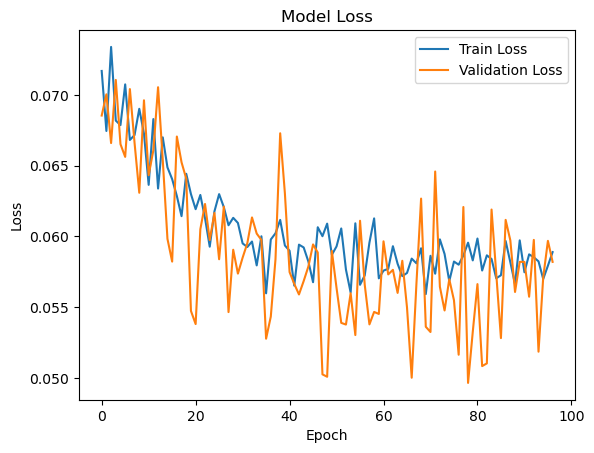

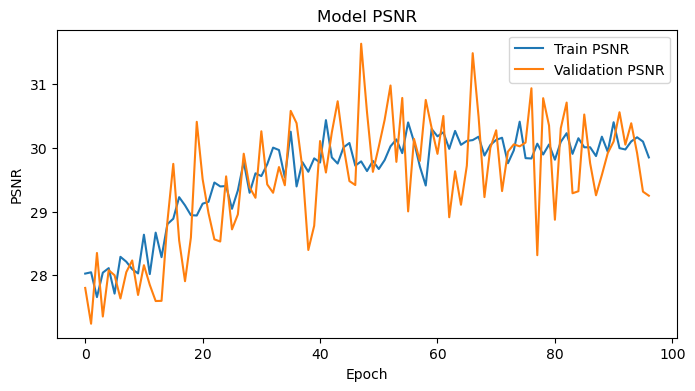

In [14]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()


# Bigger the PSNR value is, more prediction and original high res images are same
plt.figure(figsize=(8, 4))
plt.plot(history.history['PSNR'], label='Train PSNR')
plt.plot(history.history['val_PSNR'], label='Validation PSNR')
plt.title('Model PSNR')
plt.ylabel('PSNR')
plt.xlabel('Epoch')
plt.legend()

plt.show()

#### Test

This block demonstrates how the model performs super-resolution on a degraded full-size image.

To simulate a low-resolution image:
- The original high-resolution image is downscaled using area interpolation (which preserves structural detail).
- It is then upscaled back to the original size using nearest-neighbor interpolation, introducing visible blockiness and pixelation.
- This artificially degraded image is fed into the model to generate a super-resolved output.

1/1 [==============================] - 4s 4s/step


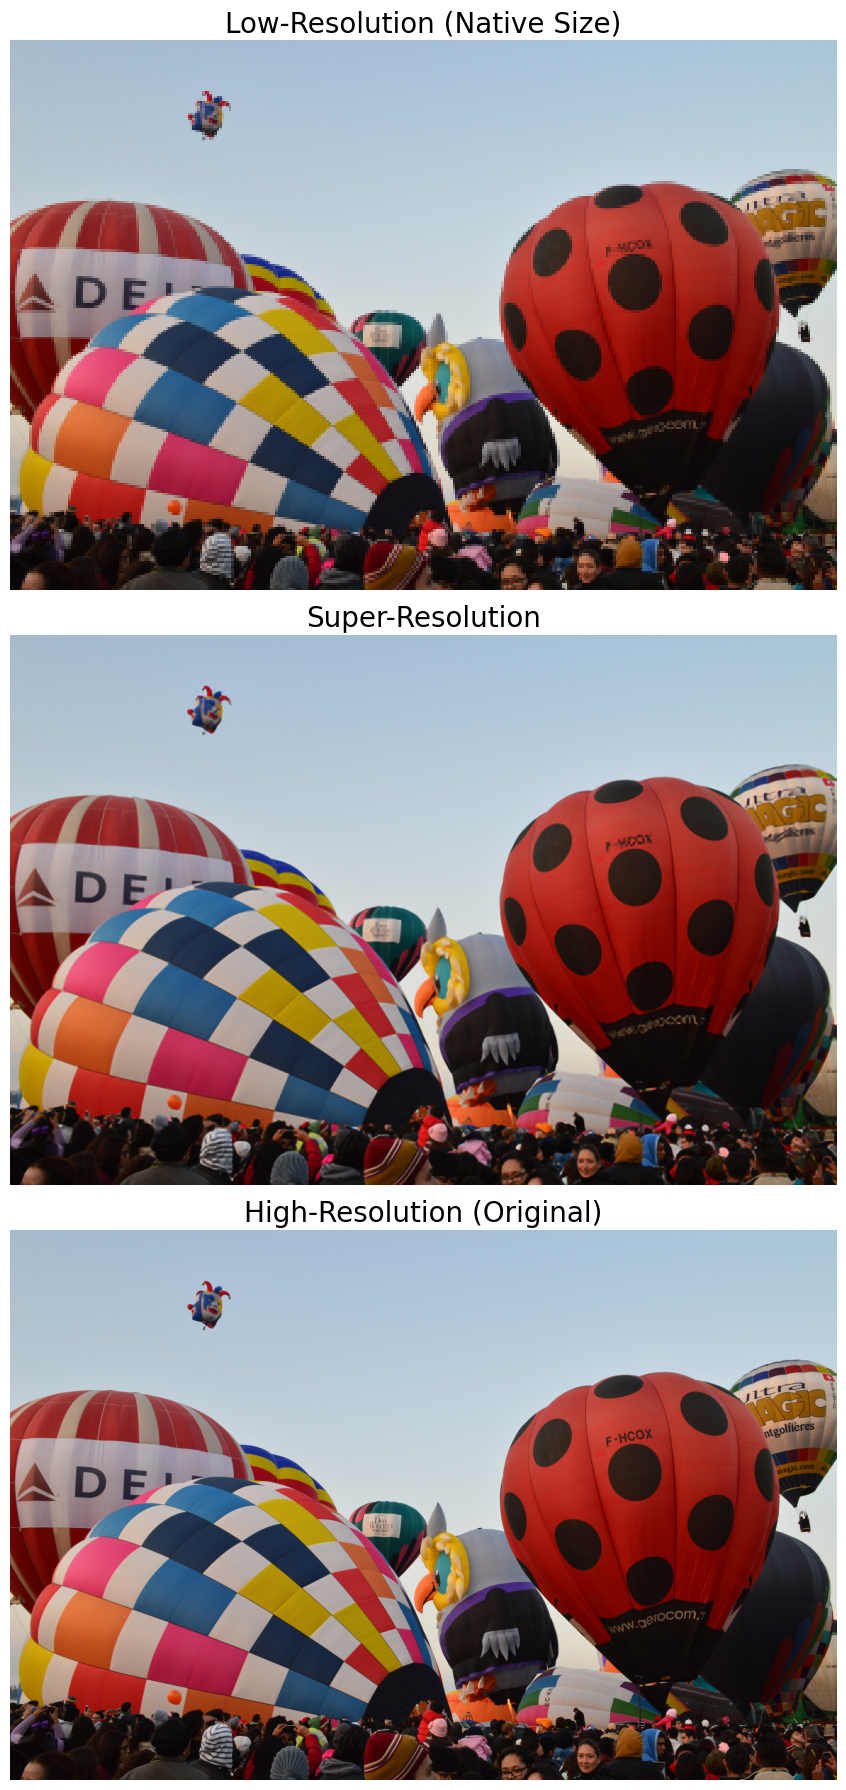

In [15]:
N = 7
for i, hr_img in enumerate(test_ds):
    if i == N:
        hr_img = hr_img.numpy()
        break

# Convert image to bad quality
scale = 6
h, w = hr_img.shape[0], hr_img.shape[1]
lr_img = tf.image.resize(hr_img, [h // scale, w // scale], method="area")
lr_img_blocky = tf.image.resize(lr_img, [h, w], method="nearest").numpy()

# Predict super-resolution image
lr_input = np.expand_dims(lr_img, axis=0)
sr_img = model.predict(lr_input)

# Post-process output image
sr_img = np.squeeze(sr_img, axis=0)
sr_img_disp = np.clip(sr_img * 255.0, 0, 255).astype(np.uint8)

# Convert HR and LR images for display
hr_img_disp = np.clip(hr_img * 255, 0, 255).astype("uint8")
lr_img_disp = np.clip(lr_img_blocky * 255, 0, 255).astype("uint8")

# Plot the images
plt.figure(figsize=(18, 18))

plt.subplot(3, 1, 1)
plt.title("Low-Resolution (Native Size)", fontsize=20)
plt.imshow(lr_img_disp, interpolation='nearest')
plt.axis("off")

plt.subplot(3, 1, 2)
plt.title("Super-Resolution", fontsize=20)
plt.imshow(sr_img_disp)
plt.axis("off")

plt.subplot(3, 1, 3)
plt.title("High-Resolution (Original)", fontsize=20)
plt.imshow(hr_img_disp)
plt.axis("off")

plt.tight_layout()
plt.show()


#### Loading the model for demo

Due to large filesize and GitHub storage limitations, the pre-trained model and weights have been hosted on Google Drive.

To access files from Google Drive, this cell installs the **gdown** package into the current environment using `%pip install gdown`. If **gdown** is already installed and up to date, the command has no effect.

This script automatically checks whether the model file (`super_resolution_model.keras`) is present in your working directory:
- If the file already exists, it will simply be loaded.
- If the file is missing, it will be downloaded from Google Drive and saved to your working directory.

**Note:** Before running this cell, make sure the following cells have been executed:
- `Imports`
- `Utility Functions`

In [3]:
%pip install gdown
import gdown

def download_model_from_drive(model_path="super_resolution_model.keras", file_id=None):
    if os.path.exists(model_path):
        print(f"Model already exists at {model_path}")
        return

    if file_id is None:
        raise ValueError("file_id is required to download the model.")

    url = f"https://drive.google.com/uc?id={file_id}"
    print(f"Downloading model from {url}...")
    gdown.download(url, model_path, quiet=False)

# download_model_from_drive(file_id="1c2jvn_g-inZwMBd_vvbj4-qQLwfhIq3Z") # legacy .h5 format
download_model_from_drive(file_id="1vrXrsplXC0FuTyOZ4y3sQ-TRQQEWW-R9") # Keras 3 format

saved_model = load_model("super_resolution_model.keras")

Note: you may need to restart the kernel to use updated packages.
Model already exists at super_resolution_model.keras


In [4]:
from esrgan_util import get_model
esrgan_model = get_model()

Loading model: https://tfhub.dev/captain-pool/esrgan-tf2/1


In [12]:
from PIL import Image

'''def esrgan_input(image: np.ndarray):
    hr_image = tf.convert_to_tensor(image, dtype=tf.float32)

    hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
    hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])

    img_pil = Image.fromarray(tf.cast(hr_image, tf.uint8).numpy())
    new_size = (img_pil.width // 4, img_pil.height // 4)
    img_downscaled = img_pil.resize(new_size, Image.BICUBIC)

    lr_image = tf.convert_to_tensor(np.array(img_downscaled), dtype=tf.float32)

    return tf.expand_dims(lr_image, axis=0)'''
    
def esrgan_input(image: np.ndarray):
    if image.dtype != np.uint8:
        image = np.clip(image, 0, 255).astype(np.uint8)
    h, w = image.shape[:2]
    
    # Only downscale if image is large enough
    if h >= 1050 and w >= 1050:
        img_pil = Image.fromarray(image)
        new_size = (img_pil.width // 4, img_pil.height // 4)
        img_downscaled = img_pil.resize(new_size, Image.BICUBIC)
        lr_image = np.array(img_downscaled)
    else:
        # If already small, just use as is
        lr_image = image
    # Add batch dimension
    return tf.expand_dims(lr_image.astype(np.float32), axis=0)

#### Model demo

This section provides a simple UI built with Gradio to demonstrate the functionality of the super-resolution model.

---

**Prerequisites**

Before running this demo, ensure the `Loading the model for demo` cell has been executed.

---

**Setup and Configuration:**


The model was trained, saved and loaded using a GPU environment with the following setup:

  - **Python**: 3.10.16
  - **Keras**: 2.10.0
  - **TensorFlow**: 2.10.1
  - **NumPy**: 1.26.4

Attempts to load the model in a different interpreter (with newer versions of Python, TensorFlow, or Keras) failed — likely due to version incompatibilities between these libraries. Additionally, newer versions of NumPy caused import errors in this setup.

**Note**: If you're unable to run this cell, ensure your environment matches the configuration above to avoid compatibility issues when loading the model.

In [13]:
def super_resolve_large_image(model, input_img, patch_size=256, overlap=32):
    """
    Super-resolve a large image by tiling it into patches.
    Args:
        model: Trained super-resolution model.
        input_img: NumPy array, shape (H, W, 3), float32 in [0,1].
        patch_size: Size of each patch to process.
        overlap: Overlap between patches to avoid seams.
    Returns:
        Super-resolved image as NumPy array.
    """
    h, w, c = input_img.shape
    scale = 4  # Change if your model uses a different scale

    out_h, out_w = h * scale, w * scale
    output_img = np.zeros((out_h, out_w, c), dtype=np.float32)
    weight_mask = np.zeros((out_h, out_w, c), dtype=np.float32)

    stride = patch_size - overlap
    for y in range(0, h, stride):
        for x in range(0, w, stride):
            patch = input_img[y : y + patch_size, x : x + patch_size, :]
            patch_h, patch_w = patch.shape[:2]
            patch_input = np.expand_dims(patch, axis=0)
            sr_patch = model(patch_input)
            
            if hasattr(sr_patch, "numpy"):
                sr_patch = sr_patch.numpy()
            if sr_patch.shape[0] == 1:
                sr_patch = sr_patch[0]
            
            y1, x1 = y * scale, x * scale
            y2, x2 = y1 + patch_h * scale, x1 + patch_w * scale
            output_img[y1:y2, x1:x2, :] += sr_patch[
                : patch_h * scale, : patch_w * scale, :
            ]
            weight_mask[y1:y2, x1:x2, :] += 1.0

    # Avoid division by zero
    output_img /= np.maximum(weight_mask, 1e-8)
    return np.clip(output_img, 0, 1)


def superRes(input_img, model_choice):
    print(f"malli: {model_choice}")

    if model_choice == "Super Resolution Model":
        model = saved_model
        img_array = input_img.astype(np.float32) / 255.0
    elif model_choice == "ESRGAN":
        model = esrgan_model
        lr_image = esrgan_input(input_img)
        sr_tensor = model(lr_image)
        sr_img = tf.squeeze(sr_tensor).numpy()
        return np.clip(sr_img, 0, 255).astype(np.uint8)
    else:
        raise ValueError("Unknown model choice")

    sr_img = super_resolve_large_image(model, img_array, patch_size=256, overlap=32)
    return (sr_img * 255).astype(np.uint8)


demo = gr.Interface(
    fn=superRes,
    inputs=[
        gr.Image(type="numpy", label="input"),
        gr.Dropdown(
            choices=["Super Resolution Model", "ESRGAN"],
            label="Choose model",
            value="Super Resolution Model",
        )
    ],
    outputs=gr.Image(label="output"),
)


if __name__ == "__main__":
    demo.launch(share=True)

* Running on local URL:  http://127.0.0.1:7864
* Running on public URL: https://938a5fb622b081583a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


malli: ESRGAN


## Summary

Our trained model is capable of generating high-resolution images from low-resolution inputs. The results are good, but there is still room for improvement. For example: The text in the images is not always readable, and the model sometimes struggles with complex textures. Model cannot properly hallucinate missing details.

Possible improvements:

Use a larger dataset for training
Use a more advanced model architecture
Use GAN model for training. This could help to generate more realistic images.
Progressive Upscaling. Instead of directly upscaling by a large factor (4x), perform progressive upscaling in smaller steps (2x followed by another 2x). This can improve stability and quality.